In [1]:
import random
import time
from copy import copy

import cv2
import numpy as np
from ipycanvas import Canvas, hold_canvas
from IPython.display import clear_output, display
from PIL import Image
from tqdm.notebook import trange

In [2]:
filename = "Orginals/Elk.jpg"
canvas_background_color = "#000000"
world_life = 35
respawn_time = 10
ppi = 75

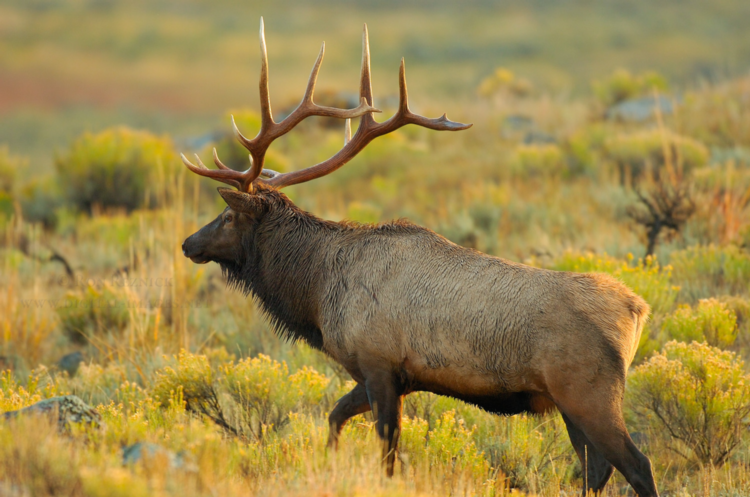

In [3]:
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.pyrDown(image)
display(Image.fromarray(image))

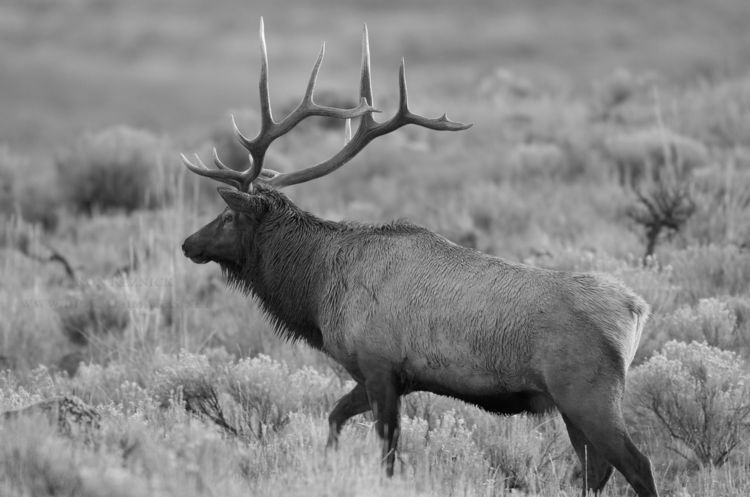

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
display(Image.fromarray(gray))

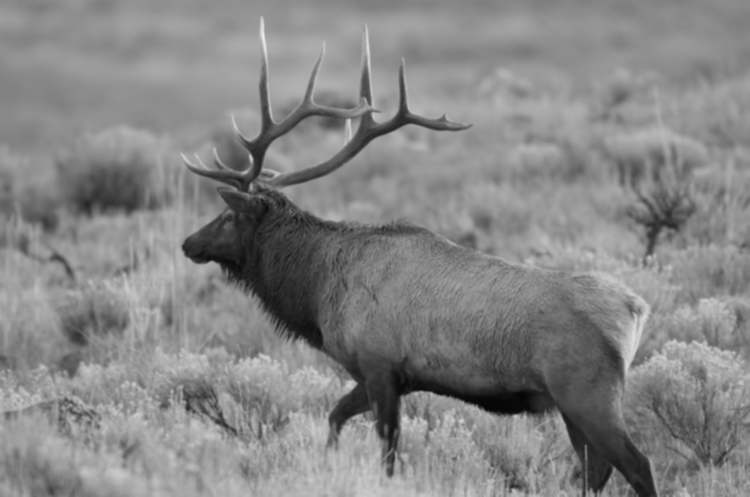

In [5]:
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
display(Image.fromarray(blurred))

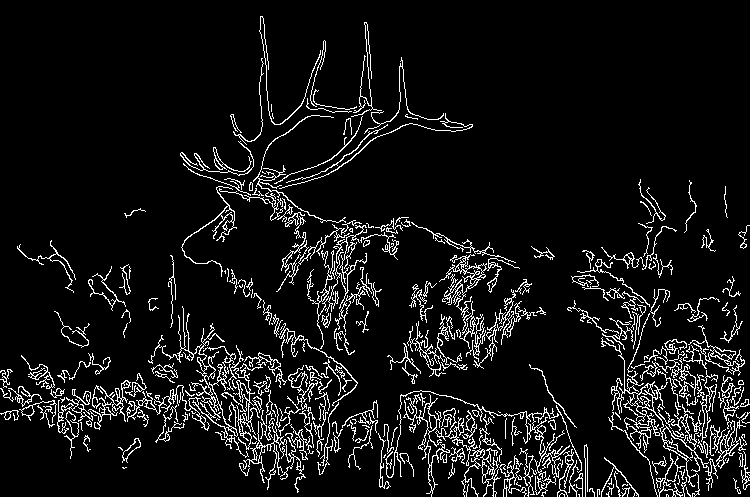

In [6]:
mid = cv2.Canny(blurred, 30, 150)
display(Image.fromarray(mid))

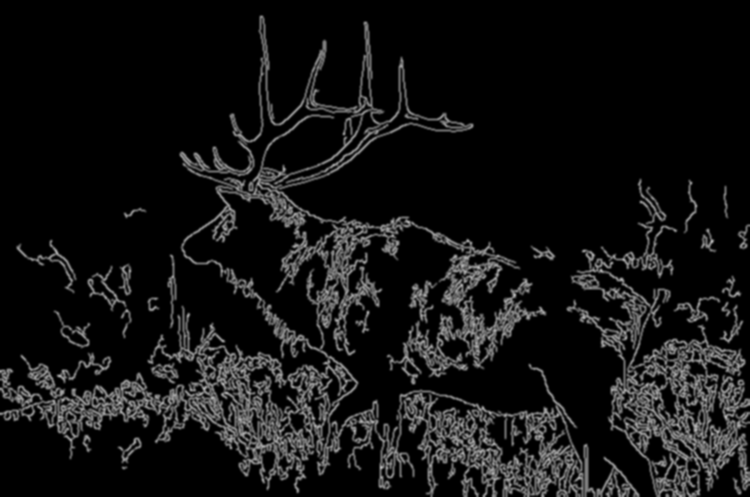

In [7]:
blurred_mids = cv2.GaussianBlur(mid, (5, 5), 0)
display(Image.fromarray(blurred_mids))

In [8]:
world_width = image.shape[1] - 1
world_height = image.shape[0] - 1
canvas = Canvas(width=world_width, height=world_height)
canvas.fill_style = canvas_background_color
canvas.fill_rect(0, 0, world_width, world_height)
display(canvas)

Canvas(height=496, width=749)

In [9]:
def analyze(c, u, d, l, r, m, last_two):
    scores = {
        "up": u,
        "down": d + random.randint(0, 15),
        "left": l + random.randint(0, 15),
        "right": r + random.randint(0, 15),
    }
    top = max(scores, key=lambda e: scores.get(e))
    if top in last_two:
        return "down"
    return top

In [10]:
class Crawler:
    def __init__(self, x, y, base_color=None, life=500):
        self.x = x
        self.y = y

        self.ox = copy(x)
        self.oy = copy(y)
        self.life = life
        self.olife = copy(life)
        self.history = []

    def run(self, world):
        global blurred, image, gray, blurred_mids
        updates = {}
        current_g = blurred_mids[self.y][self.x]
        current = blurred_mids[self.y][self.x]

        up = (
            blurred_mids[self.y - 1][self.x]
            if (
                self.y - 1 < world_height
                and self.y - 1 > 0
                and self.x < world_width
                and self.x > 0
            )
            else 0
        )
        down = (
            blurred_mids[self.y + 1][self.x]
            if (
                self.y + 1 < world_height
                and self.y - 1 > 0
                and self.x < world_width
                and self.x > 0
            )
            else 0
        )
        left = (
            blurred_mids[self.y][self.x + 1]
            if (
                self.y < world_height
                and self.y > 0
                and self.x + 1 < world_width
                and self.x + 1 > 0
            )
            else 0
        )
        right = (
            blurred_mids[self.y][self.x - 1]
            if (
                self.y < world_height
                and self.y > 0
                and self.x - 1 < world_width
                and self.x - 1 > 0
            )
            else 0
        )
        meta = [up, down, left, right]
        meta = sum(meta) / len(meta)
        mode = analyze(current, up, down, left, right, meta, self.history)
        self.history.append(mode)
        self.history = self.history[:-5]
        if mode == "up":
            self.x += 0
            self.y += -1

        elif mode == "left":
            self.x += 1
            self.y += 0

        elif mode == "right":
            self.x += -1
            self.y += 0

        elif mode == "down":
            self.x += 0
            self.y += 1

        # respawn
        if self.life > 0:
            self.life -= 1
        else:
            self.life = copy(self.olife)
            self.x = random.randint(0, world_width)
            self.y = random.randint(0, world_height)

        if self.y < 0:
            self.y = world_height

        if self.y > world_height:
            self.y = 0

        if self.x < 0:
            self.x = world_width

        if self.x > world_width:
            self.x = 0

        if self.x <= 0:
            self.x = world_width

        r, g, b = image[self.y][self.x]
        updates[(self.x, self.y)] = f"rgb({r},{g},{b})"

        valid = False
        return updates

In [11]:
class World:
    data = {}
    actors = []
    data_since_last_update = {}

    def __init__(self, width, height):
        self.width = width
        self.height = height

    def update(self, update_data):
        self.data.update(update_data)
        self.data_since_last_update.update(update_data)

    def updateCanvas(self, canvas):
        for loc in self.data_since_last_update:
            x, y = loc
            canvas.fill_style = self.data_since_last_update[loc]
            canvas.fill_rect(x, y, 1, 1)
        self.data_since_last_update = {}

In [12]:
def update(world):
    for ap in world.actors:
        world.update(ap.run(world))
    world.updateCanvas(canvas)

In [13]:
world = World(world_width, world_height)
for y in range(1, ppi):
    for x in range(1, ppi):
        world.actors.append(
            Crawler(
                int((world_width / ppi) * x),
                int((world_height / ppi) * y),
                life=respawn_time,
            )
        )

In [14]:
for _ in trange(world_life):
    with hold_canvas(canvas):
        update(world)

  0%|          | 0/35 [00:00<?, ?it/s]

In [15]:
canvas.sync_image_data = True

In [16]:
time.sleep(5)
canvas.to_file(f"{filename}.output.png")
canvas.sync_image_data = False

RuntimeError: No image data to save, please be sure that ``sync_image_data`` is set to True

# 